<a href="https://colab.research.google.com/github/szh141/colab/blob/main/match_template_and_np_dot_plot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Part I out of III

https://github.com/guiwitz/neubias_academy_biapy/blob/master/09-Pattern_matching.ipynb

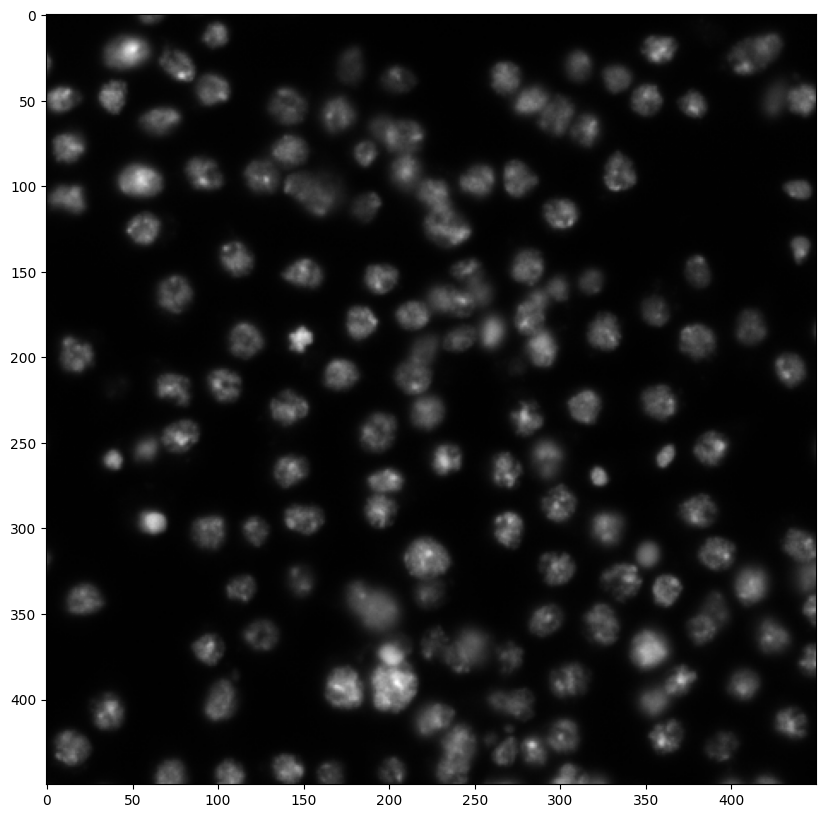

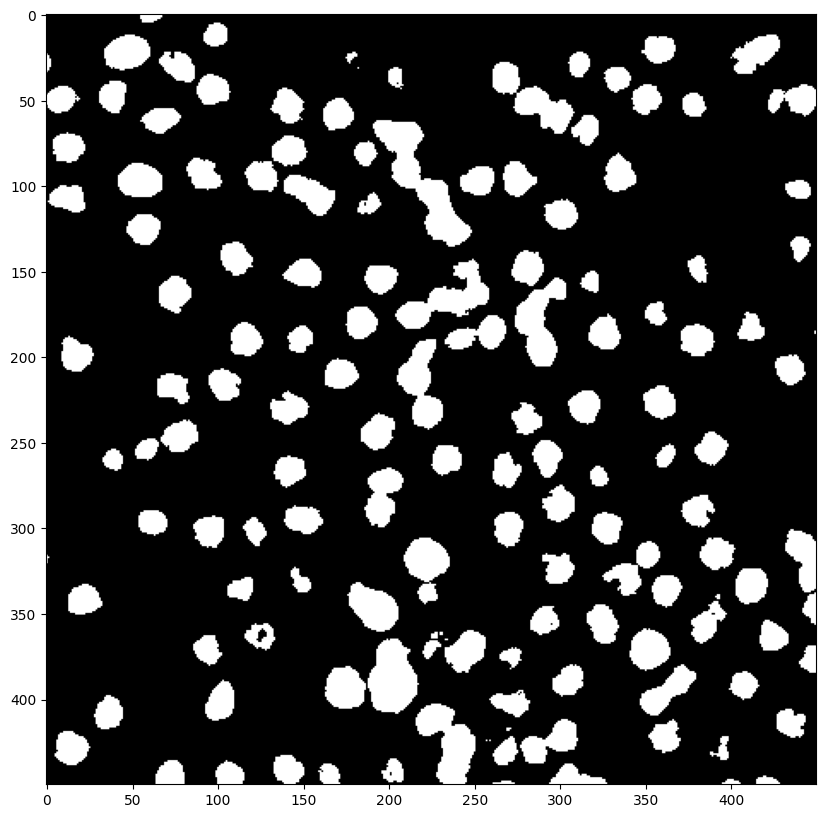

In [ ]:
from skimage import io,filters
from matplotlib import pyplot as plt

img = io.imread('/content/drive/MyDrive/Colab images/Data/BBBC007_v1_images/A9/A9 p9d.tif')
plt.figure(figsize=(10,10))
plt.imshow(img,cmap='gray')
plt.show()

mask = img > filters.threshold_otsu(img)
plt.figure(figsize=(10,10))
plt.imshow(mask,cmap='gray')
plt.show()

#watershed, stardist

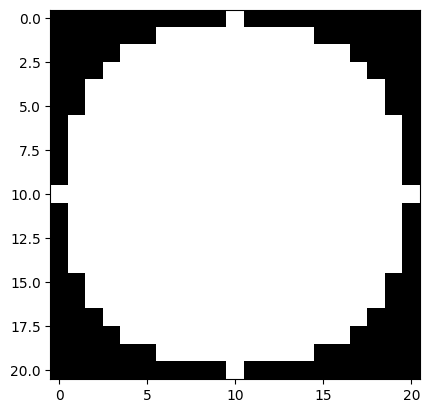

In [ ]:
from skimage import morphology
template = morphology.disk(10)
plt.imshow(template,cmap='gray')
"""
import numpy as np
radius = 10

template = np.zeros((21,21))
center = [(template.shape[0]-1)/2,(template.shape[1]-1)/2]
Y, X = np.meshgrid(range(template.shape[0]),range(template.shape[1]))
dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)
template[dist_from_center<=radius] = 1

plt.imshow(template)
"""

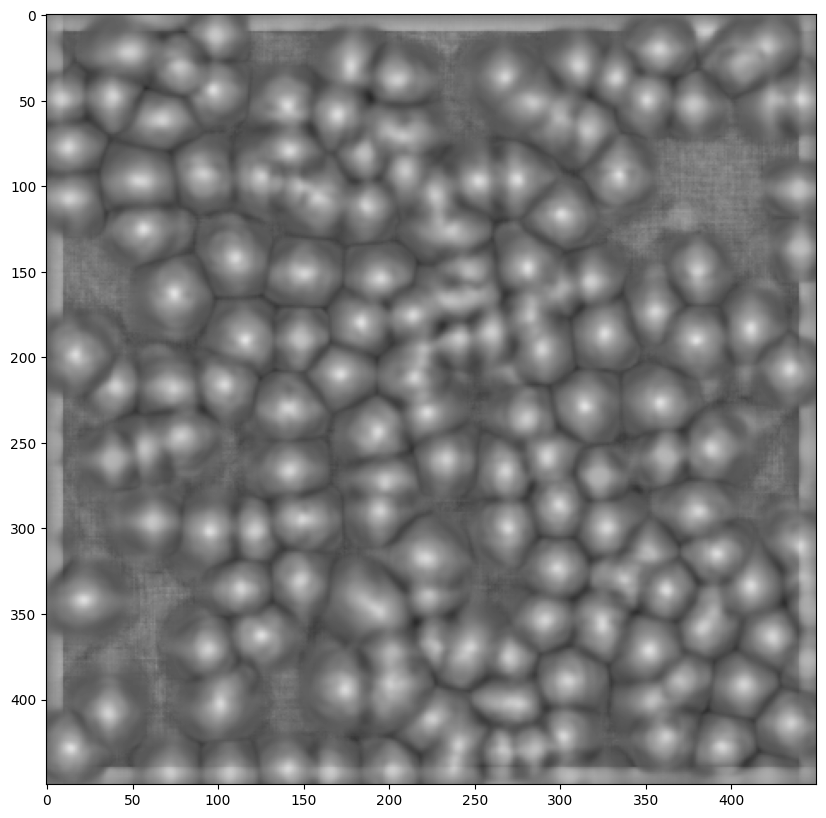

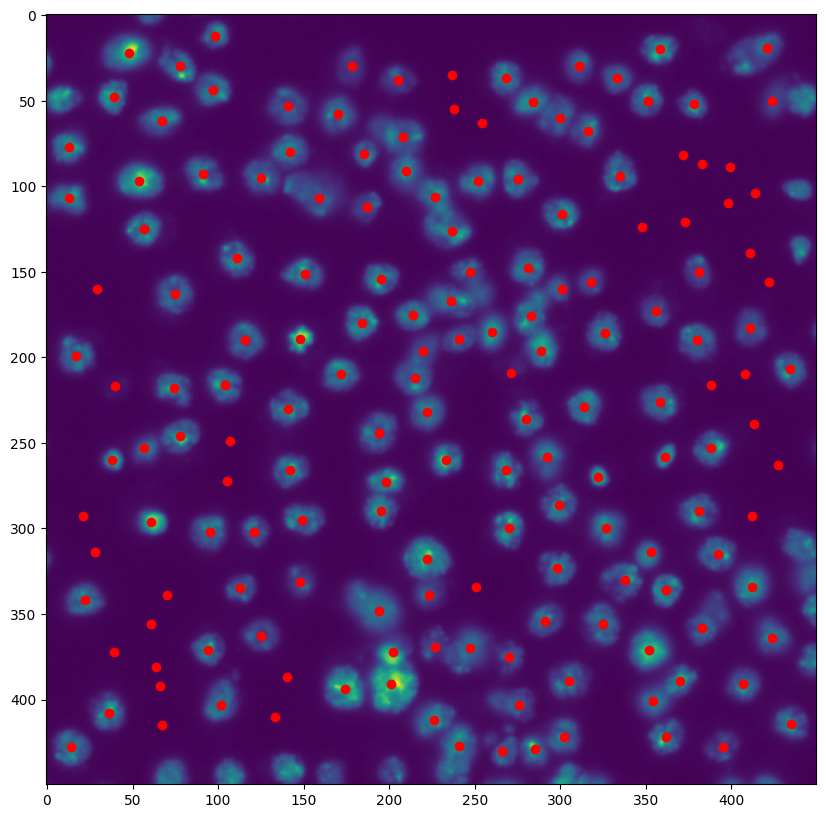

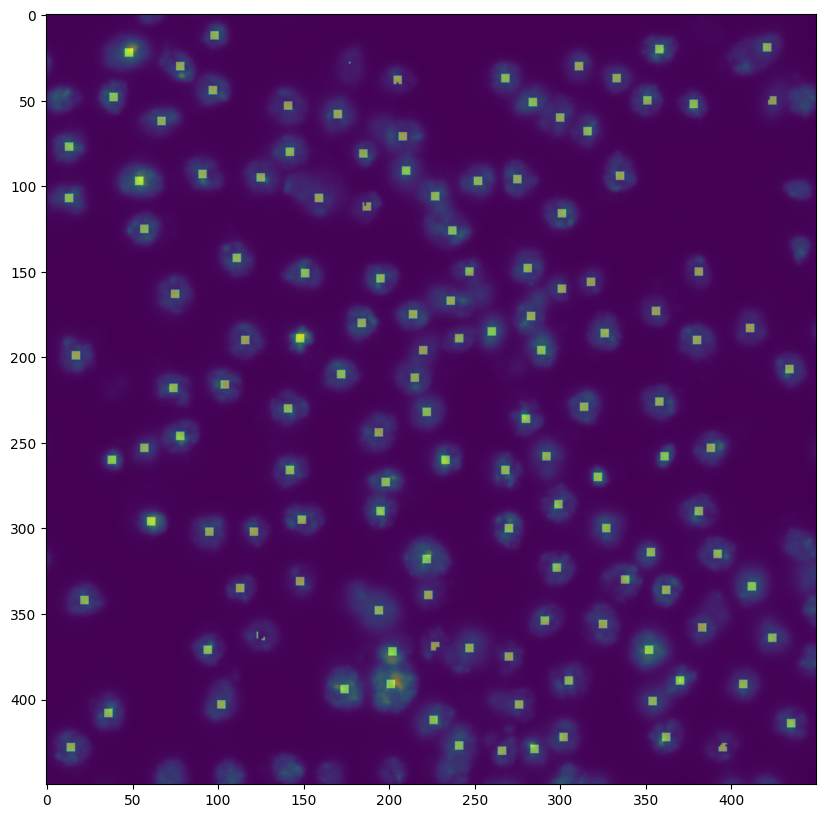

In [ ]:
from skimage.feature import match_template, peak_local_max
matched = match_template(image=img, template=template, pad_input=True)
plt.figure(figsize=(10,10))
plt.imshow(matched, cmap = 'gray', vmin = -1, vmax = 1);
plt.show()

local_max_indices = peak_local_max(matched, min_distance=10)
plt.figure(figsize=(10,10))
plt.imshow(img)
plt.plot(local_max_indices[:,1],local_max_indices[:,0],'ro');
plt.show()

local_max = np.zeros(mask.shape)
local_max[local_max_indices[:,0],local_max_indices[:,1]] = 1
# image, (indices[:,0],indices[:1]); plot, (indices[:,1],indices[:0])
local_max = morphology.dilation(local_max,footprint=np.ones((5,5)))
masked_local_max = mask * local_max
plt.figure(figsize=(10,10))
plt.imshow(img)
plt.imshow(masked_local_max,alpha = 0.5)
plt.show()


EM virus image, template match

similar shape

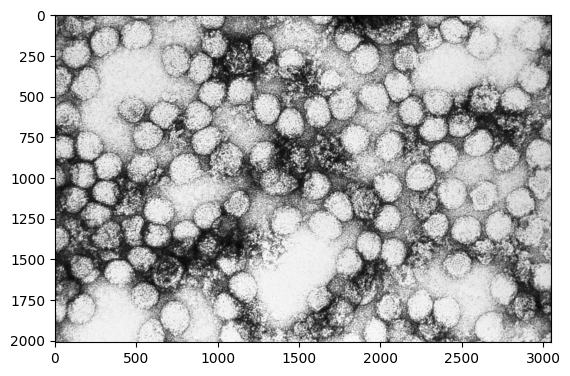

In [ ]:
from skimage.feature import match_template, peak_local_max
import skimage.io as io
import numpy as np
import matplotlib.pyplot as plt

img = io.imread('/content/drive/MyDrive/Colab images/Data/virus_EM.tif')
plt.imshow(img,cmap='gray')

play with disk size 90 vs 180, it matters

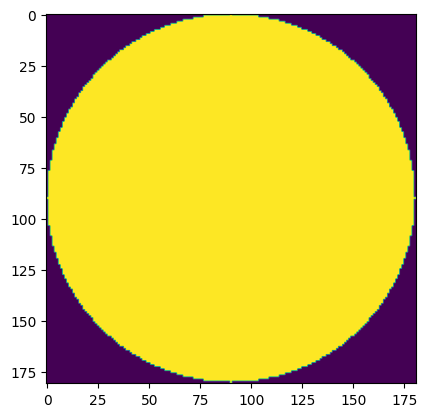

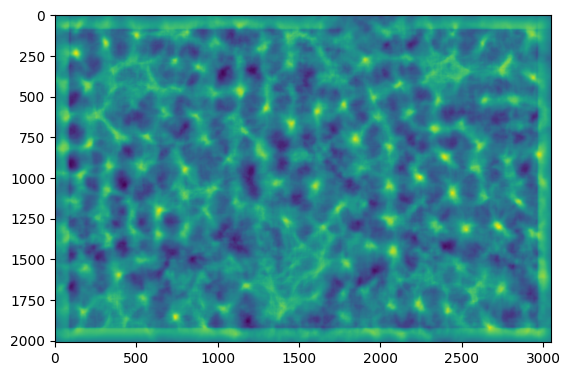

In [ ]:
from skimage.morphology import disk
template = disk(90)
plt.imshow(template)
plt.show()
matched = match_template(image=img, template=template, pad_input=True)
plt.imshow(matched)
plt.show()


We can try to detect the local maxima to have the position of each particle. We specify that two maximia cannot be closer than 80 pixels (min_distance) and we also set a threshold on the quality of matching (threshold_abs). We also want to recover a list of indices rather than a binary mask of local maxima.

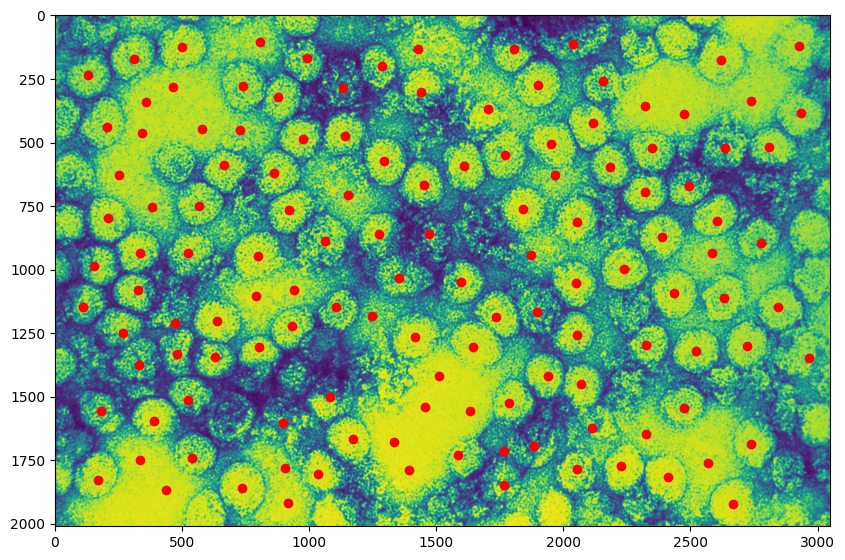

In [ ]:
local_max_indices = peak_local_max(matched, min_distance=80, threshold_abs=0.2)
plt.figure(figsize=(10,10))
plt.imshow(img)
plt.plot(local_max_indices[:,1],local_max_indices[:,0],'ro')
plt.show()

Part II out of III


https://github.com/guiwitz/neubias_academy_biapy/blob/master/12-Registration.ipynb

image registration using template match

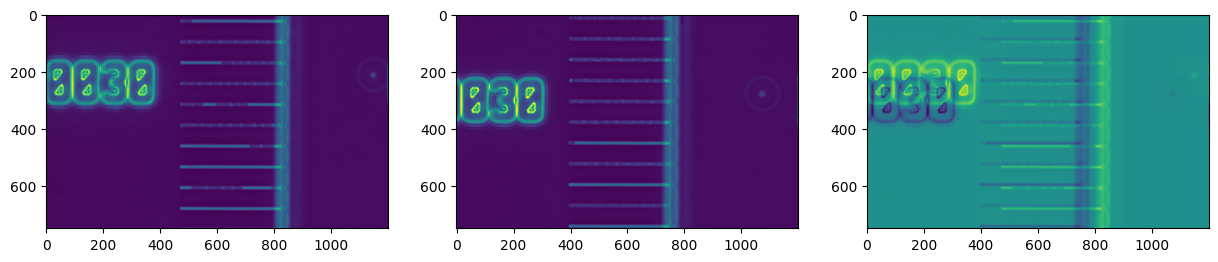

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import skimage.io as io

from skimage.feature import match_template
from skimage.filters import threshold_otsu

image1 = io.imread('/content/drive/MyDrive/Colab images/Data/channels/channels1.tif')[0:750,:]
image2 = io.imread('/content/drive/MyDrive/Colab images/Data/channels/channels2.tif')[0:750,:]

fig, ax = plt.subplots(1,3, figsize=(15,10))
ax[0].imshow(image1)
ax[1].imshow(image2)
#ax[2].imshow(image1 - image2)
ax[2].imshow(image1.astype(float)-image2.astype(float));

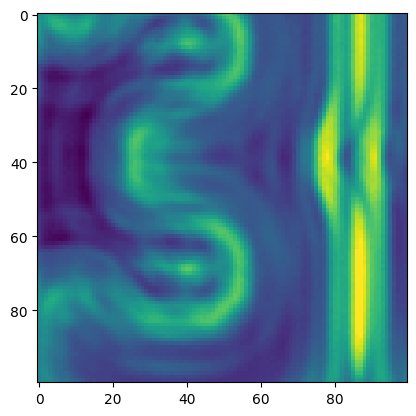

In [ ]:
template_center = [250,250]
reference_region = image1[
    template_center[0]-50:template_center[0]+50,
    template_center[1]-50:template_center[1]+50
]
plt.imshow(reference_region)

np.argmax + np.unravel_index to find the registration coord

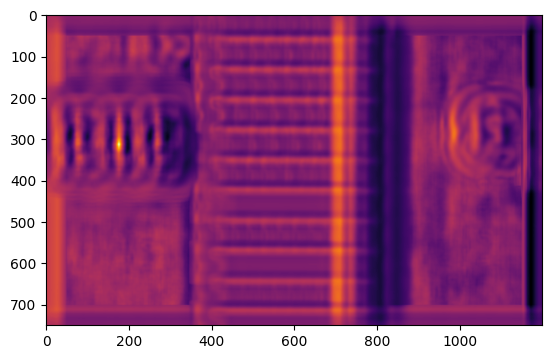

maxpos is 374576
maxpos is (312, 176)


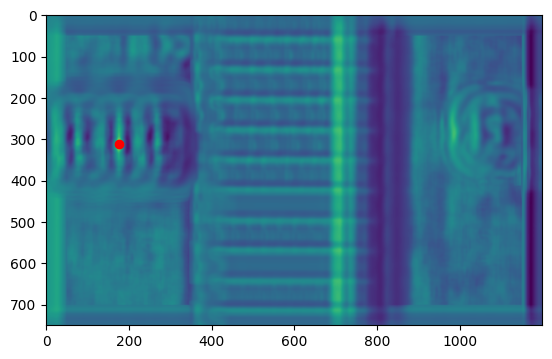

In [ ]:
matched = match_template(image2, reference_region, pad_input=True)
plt.imshow(matched, cmap = 'inferno')
plt.show()
maxpos = np.argmax(matched)
print(f'maxpos is {maxpos}')
maxpos = np.unravel_index(maxpos, matched.shape)
print(f'maxpos is {maxpos}')
plt.imshow(matched)
plt.plot([maxpos[1]],[maxpos[0]],'ro');
plt.show()



[-62  74]


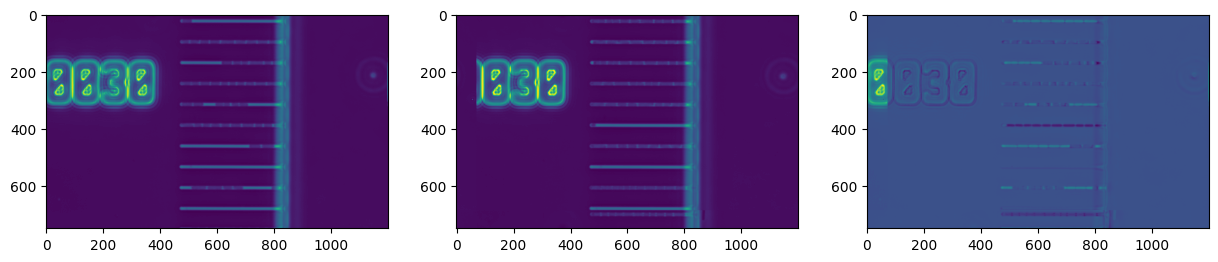

In [ ]:
displacement = template_center - np.array(maxpos)
print(displacement)
image2_shift = np.roll(image2, shift = displacement, axis = (0,1))

fig, ax = plt.subplots(1,3, figsize=(15,10))
ax[0].imshow(image1)
ax[1].imshow(image2_shift)
ax[2].imshow(image1.astype(float)-image2_shift.astype(float));

In our first approach we had to manually select a reference object. That approach is also limited to finding simple translations. A more general approach to the problem is to let an algorithm find for us points of interest that can serve as landmarks for registration. In particular those landmarks should be "immune" to image transformations such as rotations, affine transformations etc.

Also, check this post. SIFT and SURF.

https://medium.com/@evertongomede/template-matching-an-insight-into-computer-visions-fundamental-technique-cff9765cd64e

Part III out of III

np.dot for image registration

https://github.com/RMS-DAIM/Python-for-Bioimage-Analysis/blob/master/sessions/day02-segmentation-and-colocalization/02_colocalization/2019_IAFIG_colocalization_practicalanswers.ipynb


shape of img:  (2, 167, 261) bit-depth:  float64


Text(0.5, 1.0, 'RGB overlay')

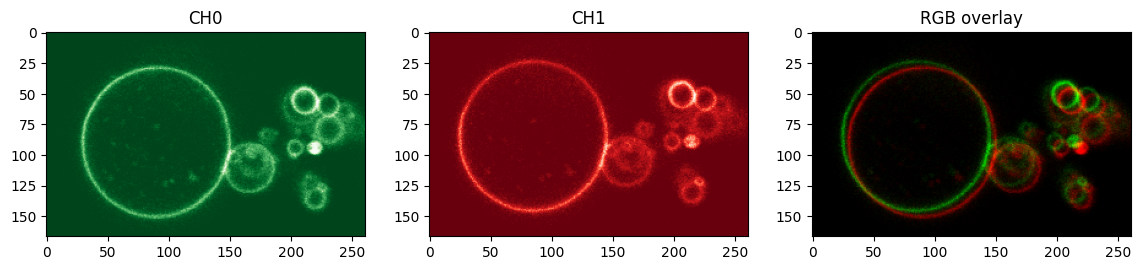

In [5]:
from skimage import io,img_as_float
from matplotlib import pyplot as plt
import numpy as np

img = io.imread('/content/drive/MyDrive/Colab images/composite.tif')
img =  img_as_float(img)

#The organisation of this file is not simple. It is also a 16-bit image.
print("shape of img: ",img.shape,"bit-depth: ",img.dtype)

#We can assess the image data like so.
CH0 = img[0,:,:]
CH1 = img[1,:,:]

fig, ax = plt.subplots(1,3, figsize=(14, 4))
#Single channels visualisation can handle 16-bit
ax[0].imshow(CH0,cmap='Greens_r')
ax[0].set_title('CH0')
ax[1].imshow(CH1,cmap='Reds_r');
ax[1].set_title('CH1')
#For the display, RGB needs to be three channel.
imRGB = np.zeros((CH0.shape[0],CH0.shape[1],3))
imRGB[:,:,0] = CH0
imRGB[:,:,1] = CH1
ax[2].imshow(imRGB);
ax[2].set_title('RGB overlay')

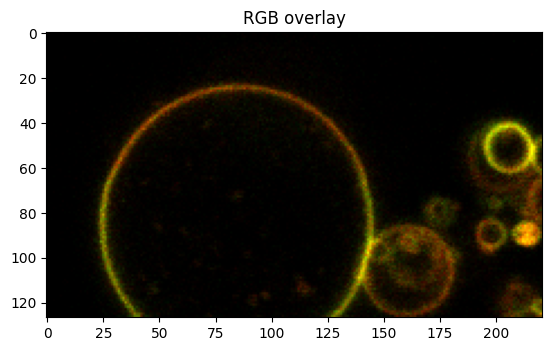

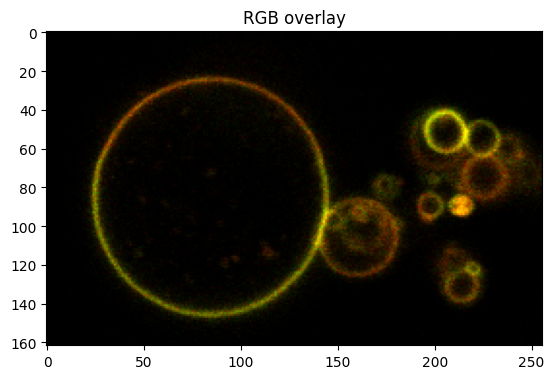

In [11]:
#devise a way of registering this image using the Pearson's test
#move one of the images relative to the other and measure the colocalisation in this position.

rho_max = 0
#sample CH0 in 40 steps
#to keep the same dimension, ref needs to be [:-40],[:-40]

for r in range(1,40):
    for c in range(1,40):
        temp = CH0[r:-40+r,c:-40+c].reshape(-1);
        ref = CH1[:-40,:-40].reshape(-1);

        #rho = np.dot(temp-np.average(temp),ref-np.average(ref))/np.sqrt(((np.dot(temp-np.average(temp),temp-np.average(temp)))*np.dot(ref-np.average(ref),ref-np.average(ref))))
        rho = np.dot(temp-np.average(temp),ref-np.average(ref))/np.sqrt((np.sum(np.square(temp-np.average(temp)))*np.sum(np.square(ref-np.average(ref)))))

        #You will need to work out the highest rho value is recorded.
        #You will then need to find the coordinates of this high rho.
        if rho > rho_max:
            rho_max = rho
            best_shift_x = r
            best_shift_y = c

#For the display, RGB needs to be three channel.


imRGB = np.zeros((CH0.shape[0]-40,CH0.shape[1]-40,3))
imRGB[:,:,0] = CH0[best_shift_y:-40+best_shift_y,best_shift_x:-40+best_shift_x]
imRGB[:,:,1] = CH1[:-40,:-40]
plt.imshow(imRGB);
plt.title('RGB overlay')
plt.show()

#the following shows more intact overlay image
imRGB = np.zeros((CH0.shape[0]-best_shift_y,CH0.shape[1]-best_shift_x,3))
imRGB[:,:,0] = CH0[best_shift_y:,best_shift_x:]
imRGB[:,:,1] = CH1[:-best_shift_y,:-best_shift_x]
plt.imshow(imRGB);
plt.title('RGB overlay')


Mander's coeff, co-occurence

Peason's coeff, co-relation

In [17]:
import matplotlib.pyplot as plt
from skimage import data, img_as_float,color, img_as_ubyte
from skimage import color, io
from skimage.filters import threshold_otsu
import scipy
import numpy as np

In [18]:
#import Mander's example.
img = io.imread('/content/drive/MyDrive/Colab images/C5aR_LAMP-1_cell003.tif')


#Convert image to float.\\\\\
img = img_as_float(img)
#Split channels.
img_dapi = img[:,:,2]
img_ch1 = img[:,:,0]
img_ch2 = img[:,:,1]

#Calculate thresholds
thr_ch1 = threshold_otsu(img_ch1)
thr_ch2 = threshold_otsu(img_ch2)

#Apply thresholds and generate binary images.
binary_ch1 = img_ch1 > thr_ch1
binary_ch2 = img_ch2 > thr_ch2

binary_chB = binary_ch1 & binary_ch2

M1 = np.sum(binary_chB)/np.sum(binary_ch1)
M2 = np.sum(binary_chB)/np.sum(binary_ch2)

print("M1",M1)
print("M2",M2)


M1 0.9564220183486238
M2 0.22937293729372937


image dimensions (512, 512, 4)  im dtype: uint8


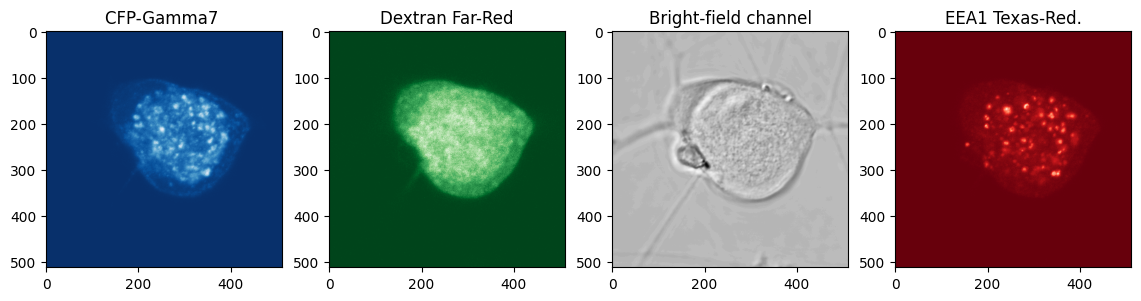

In [20]:
#Here is an image which has 4 channels.

img = io.imread('/content/drive/MyDrive/Colab images/neuron.tif')
print('image dimensions',img.shape, ' im dtype:',img.dtype)
img = img_as_float(img)

fig, ax = plt.subplots(1,4, figsize=(14, 4))
ax[0].imshow(img[:,:,0],cmap='Blues_r')
ax[0].set_title('CFP-Gamma7 ')
ax[1].imshow(img[:,:,1],cmap='Greens_r')
ax[1].set_title('Dextran Far-Red')
ax[2].imshow(img[:,:,2],cmap='Greys_r')
ax[2].set_title('Bright-field channel')
ax[3].imshow(img[:,:,3],cmap='Reds_r')
ax[3].set_title('EEA1 Texas-Red.');

In [21]:
#Calculate the Pearson's coefficent (rho) for the image channel 0, 3.
X = img[:,:,0].reshape(-1)
Y = img[:,:,3].reshape(-1)

X_bar = np.average(X)
Y_bar = np.average(Y)

rho = np.sum((X-X_bar)*(Y-Y_bar))/(np.sqrt(np.sum((X-X_bar)**2))*(np.sqrt(np.sum((Y-Y_bar)**2))))####Insert the remaining code here to finish the equation.
print('rho',rho)

rho 0.829104646364742


In [22]:
#The mask channel is a dextran dye which was injected into the cell.
msk = img[:,:,1]
#Lets threshold it with Otsu.
thr_ch1 = threshold_otsu(msk)
binary_mask = msk>thr_ch1

#Now we want the pixel indices which are positive in the image.
msk_indices = np.nonzero(binary_mask)

#Calculate the Pearson's coefficent (rho) for the image channel 0, 3.
X_m = img[msk_indices[0],msk_indices[1],0].reshape(-1)
Y_m = img[msk_indices[0],msk_indices[1],3].reshape(-1)


X_bar = np.average(X_m)
Y_bar = np.average(Y_m)

rho = np.sum((X_m-X_bar)*(Y_m-Y_bar))/(np.sqrt(np.sum((X_m-X_bar)**2))*(np.sqrt(np.sum((Y_m-Y_bar)**2))))####Insert the remaining code here to finish the equation.
print('rho',rho)

rho 0.6776426800412125
